install huggingface transformerss library

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 26.1 MB/s 
     |████████████████████████████████| 163 kB 61.3 MB/s 
     |████████████████████████████████| 6.6 MB 49.5 MB/s 


Load Fine-Tuned Bert large

model discribtion
https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad

In [4]:
from transformers import BertForQuestionAnswering

model =BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [6]:
question="How many parameters does Bert-large have?"
context="BERT large, with 345 million parameters, is the largest model of its kind. It is\
demonstrably superior on small-scale tasks to BERT base, which uses the same architecture with 110\
million parameters.However, we need corresponding computational power to make BERT work. I\
need to learn more about how to evaluate different VMs for which task in the future. With enough\
training data, more training steps will result with a higher accuracy. For instance, the BERT base\
accuracy improves when trained on 1M steps compared to 500k steps with the same batch size\
some research paper. BERT’s bidirectional approach converges slower than left-to-right approaches,\
because only 15% of words are predicted in each batch, but bidirectional training still outperforms\
left-to-right training after a small number of pre-training steps. This is proven by compare BERT\
with BiDAF."


In [8]:
# apply the tokenizer to in put text , treatingthem as a text pair
input_ids=tokenizer.encode(question,context)

print('The input has a total of {} tokens.'.format(len(input_ids)))

The input has a total of 201 tokens.


just to see exactly what the tokenizer is doing , let's print out the tokens with their iDs.

In [11]:
tokens =tokenizer.convert_ids_to_tokens(input_ids)

for token , id in zip(tokens , input_ids):
  print(f"{token}\t\t{id}")


[CLS]		101
how		2129
many		2116
parameters		11709
does		2515
bert		14324
-		1011
large		2312
have		2031
?		1029
[SEP]		102
bert		14324
large		2312
,		1010
with		2007
345		23785
million		2454
parameters		11709
,		1010
is		2003
the		1996
largest		2922
model		2944
of		1997
its		2049
kind		2785
.		1012
it		2009
is		2003
##de		3207
##mons		16563
##tra		6494
##bly		6321
superior		6020
on		2006
small		2235
-		1011
scale		4094
tasks		8518
to		2000
bert		14324
base		2918
,		1010
which		2029
uses		3594
the		1996
same		2168
architecture		4294
with		2007
110		7287
##mill		19912
##ion		3258
parameters		11709
.		1012
however		2174
,		1010
we		2057
need		2342
corresponding		7978
computational		15078
power		2373
to		2000
make		2191
bert		14324
work		2147
.		1012
in		1999
##eed		13089
to		2000
learn		4553
more		2062
about		2055
how		2129
to		2000
evaluate		16157
different		2367
v		1058
##ms		5244
for		2005
which		2029
task		4708
in		1999
the		1996
future		2925
.		1012
with		2007
enough		2438
##train		2

we've concatenated the question and answer_text together , but Bert still needs a way to distinguish them. Bert has two special embeddings one for segment "A" and one for segment "B" .Before the word embeddings go into bert layers the segment A needs to be added to the question tokens , and the segment B embedding needs to be added to each of context token 

In [12]:
#search the input_ids for the first instance of the '[SEP]' token.
sep_index =input_ids.index(tokenizer.sep_token_id)

num_seg_a=sep_index+1
num_seg_b=len(input_ids)-num_seg_a

segment_ids=[0]*num_seg_a+[1]*num_seg_b

assert len(segment_ids)==len(input_ids)

In [32]:
import torch

dic= model(torch.tensor([input_ids]),token_type_ids=torch.tensor([segment_ids]))

now we can highlight the answer

In [45]:
answer_start =torch.argmax(dic[0])
answer_end=torch.argmax(dic[1])


answer =' '.join(tokens[answer_start:answer_end+1])
print(f"start index {answer_start} end index {answer_end}")
print(f"answer: {answer}")

start index15 end index 16
answer: 345 million


now try to reconstruct any words that got broken down into subwords

In [47]:
Answer=tokens[answer_start]
for i in range (answer_start+1 ,answer_end+1):
  if tokens[i][0:2]=="##":
    Answer +=tokens[2:]
  else :
    Answer +=" "+ tokens[i]

print(f"Answer: {Answer}")      

Answer: 345 million


Visualizing Scores

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

#use plot styling from seaborn
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"]=(16,8)

In [52]:
s_scores=dic[0].detach().numpy().flatten()
e_scores=dic[1].detach().numpy().flatten()
token_labels=[]
for (i,token) in enumerate(tokens):
  token_labels.append(token +"\t\t"+str(i))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


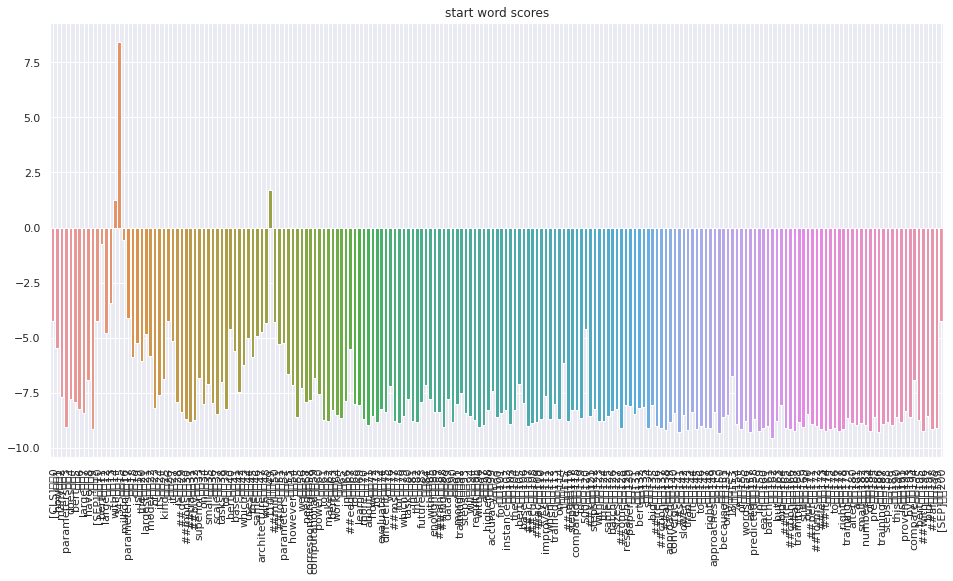

In [53]:
ax =sns.barplot(x=token_labels,y=s_scores,ci=None)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,ha="center")

ax.grid(True)
plt.title('start word scores')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


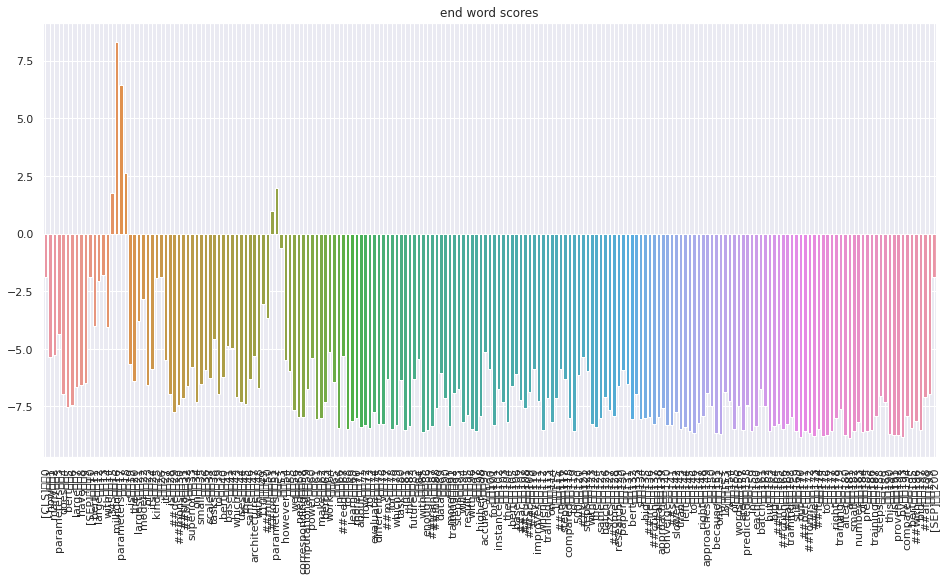

In [54]:
ax =sns.barplot(x=token_labels,y=e_scores,ci=None)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,ha="center")

ax.grid(True)
plt.title('end word scores')
plt.show()